# Model fine tunning for multiclass text classification

This notebook is used to fine tune a language model for the task of text classification into three different classes. 
It uses the previously labeled telegram data. 

In [53]:
import sys
import platform
import torch
import os
import pandas as pd
import numpy as np
import sklearn as sk
from datasets import load_dataset, load_metric, Dataset
from transformers import AutoTokenizer, AutoModelForSequenceClassification, Trainer

In [54]:
# check hardware availability
has_gpu = torch.cuda.is_available()
has_mps = torch.backends.mps.is_built()

device = "mps" if getattr(torch,'has_mps',False) \
    else "gpu" if torch.cuda.is_available() else "cpu"

print(f"Python Platform: {platform.platform()}")
print(f"PyTorch Version: {torch.__version__}")
print()
print(f"Python {sys.version}")
print(f"Pandas {pd.__version__}")
print(f"Scikit-Learn {sk.__version__}")
print("GPU is", "available" if has_gpu else "NOT AVAILABLE")
print("MPS (Apple Metal) is", "AVAILABLE" if has_mps else "NOT AVAILABLE")
print(f"Target device is {device}")

Python Platform: macOS-14.4.1-arm64-arm-64bit
PyTorch Version: 2.3.0

Python 3.9.19 (main, Mar 21 2024, 12:07:41) 
[Clang 14.0.6 ]
Pandas 2.2.1
Scikit-Learn 1.3.0
GPU is NOT AVAILABLE
MPS (Apple Metal) is AVAILABLE
Target device is mps


/var/folders/w2/1nyptw5136b9mqhj4dvgdky00000gn/T/ipykernel_27753/82983826.py:5: UserWarning: 'has_mps' is deprecated, please use 'torch.backends.mps.is_built()'
  device = "mps" if getattr(torch,'has_mps',False) \


## Dataset loading and postprocessing

The previously labeled data is split in batches. The following code loads every csv inside the given folder and merges all batches into a dataframe.

In [77]:
# Path to the folder containing the CSV files
folder_path = 'labeled'

# Get a list of all CSV files in the folder
file_list = [file for file in os.listdir(folder_path) if file.endswith('.csv')]

# Create an empty DataFrame to store the merged data
merged_df = pd.DataFrame()

# Iterate over the file list and read each CSV file into a DataFrame
for file in file_list:
    file_path = os.path.join(folder_path, file)
    df = pd.read_csv(file_path)
    
    # Merge the current DataFrame with the merged_df
    merged_df = pd.concat([merged_df, df], ignore_index=True)

# Total labeled data.
merged_df.shape

(5000, 9)

Prepare the data for pytorch training

In [78]:
def score_sentiment_multiclass(x):
  """
  Transform the text labels into codes.
  """
  if x == "positive":
    return 0

  if x == "negative":
    return 1

  if x == "neutral":
    return 2
  
  return 0


merged_df["target"] = merged_df["sentiment"].apply(score_sentiment_multiclass)
merged_df["target"] = merged_df["target"].astype(int)


# load Dataset from Pandas DataFrame
dataset = Dataset.from_pandas(merged_df[["text", "target", "sentiment","id"]])
ds = dataset.train_test_split()

In [79]:
merged_df.head(3)

,Unnamed: 0,channel_name,id,date,message,replies,token_count,text,sentiment,target
0,0,@runonflux,502754,2024-04-25 16:10:05+00:00,Value\nTotal 4815000\nStaked 4729...,"MessageReplies(replies=0, replies_pts=618073, ...",22,ValueTotal 4815000Staked 4729421F...,neutral,2
1,1,@runonflux,502753,2024-04-25 15:49:44+00:00,"🚨 FluxOS v5.4.0 will soon be enforced, introdu...",NaN,44,"FluxOS v5.4.0 will soon be enforced, introduc...",positive,0
2,2,@runonflux,502752,2024-04-25 15:33:15+00:00,"FLUX is a leading DePIN project, as we have ma...","MessageReplies(replies=0, replies_pts=618073, ...",18,"FLUX is a leading DePIN project, as we have ma...",positive,0


## Inference with pretrained transformer

Before fine tuning a model, let´s check the performance of a pretrained model on our dataset.

In [80]:
# Load tokenizer and model, create trainer

tokenizer = AutoTokenizer.from_pretrained("ProsusAI/finbert")
finbert_model = AutoModelForSequenceClassification.from_pretrained("ProsusAI/finbert", num_labels=3)

In [95]:
import matplotlib.pyplot as plt
from torch import nn
from sklearn.metrics import (accuracy_score, classification_report,
  precision_score,
  recall_score,
  f1_score,
  confusion_matrix,
  ConfusionMatrixDisplay)


def preprocess_function(examples):
    # Convert labels to one-hot encoding
    # labels = nn.functional.one_hot(torch.tensor(examples['target']), num_classes=3)
    # examples['labels'] = labels.tolist()
    return tokenizer(examples["text"], padding="max_length", truncation=True)

def compute_metrics(model, dataloader, device):
    predictions = None
    references = None
    model.eval()
    print(f"running inference on {device.type}")
    for batch in dataloader:
        batch = {k: v.to(device) for k, v in batch.items()}
        with torch.no_grad():
            outputs = model(**batch)

        logits = outputs.logits

        if predictions is None:
            predictions = torch.argmax(logits, dim=-1)
            references = batch["labels"]
        else:
            predictions = torch.cat((predictions, torch.argmax(logits, dim=-1)))
            references = torch.cat((references, batch["labels"]))
    
    return predictions, references

def report_metrics(y_pred, y_true):
    # Compute metrics for each class and globally
    report = classification_report(y_true, y_pred, output_dict=True)

    label_map = {
        "0": "positive",
        "1": "negative",
        "2": "neutral"
    }

    # Print metrics for each class
    for class_label, metrics in report.items():
        if class_label.isdigit():  # Check if the label is a class label (not 'accuracy', 'macro avg', 'weighted avg')
            print(f"\nClass: {label_map[class_label]}:")
            print(f"Precision: {metrics['precision']}")
            print(f"Recall: {metrics['recall']}")
            print(f"F1-score: {metrics['f1-score']}")

    # Print global metrics
    print("\nGlobal metrics:")
    print(f"Accuracy: {report['accuracy']}")
    print(f"Precision (weighted): {report['weighted avg']['precision']}")
    print(f"Recall (weighted): {report['weighted avg']['recall']}")
    print(f"F1-score (weighted): {report['weighted avg']['f1-score']}")

    # Confusion Matrix
    conf_matrix = confusion_matrix(y_true, y_pred)

    disp = ConfusionMatrixDisplay(conf_matrix)
    disp.plot()

    plt.show()


In [88]:
from torch.utils.data import DataLoader

test_dataset = ds["test"].map(preprocess_function, batched=True)
test_dataset = test_dataset.remove_columns(["text", "sentiment", "id"])
test_dataset = test_dataset.rename_column("target", "labels")

test_dataset.set_format("torch")
test_dataloader = DataLoader(test_dataset, batch_size=8)

Map:   0%|          | 0/1250 [00:00<?, ? examples/s]

In [89]:
# in case device was used before
torch.mps.empty_cache()
device = torch.device("cuda") if torch.cuda.is_available() else torch.device("mps") if torch.backends.mps.is_available() else torch.device("cpu")
finbert_model.to(device)

predictions, references = compute_metrics(model=finbert_model, dataloader=test_dataloader, device=device)
pred_np = predictions.cpu().numpy()
ref_np = references.cpu().numpy()

running inference on mps



Class: positive:
Precision: 0.7111111111111111
Recall: 0.11307420494699646
F1-score: 0.1951219512195122

Class: negative:
Precision: 0.6666666666666666
Recall: 0.14354066985645933
F1-score: 0.2362204724409449

Class: neutral:
Precision: 0.6336206896551724
Recall: 0.9696569920844327
F1-score: 0.7664233576642335

Global metrics:
Accuracy: 0.6376
Precision (weighted): 0.6566898084291188
Recall (weighted): 0.6376
F1-score (weighted): 0.5484307968358147


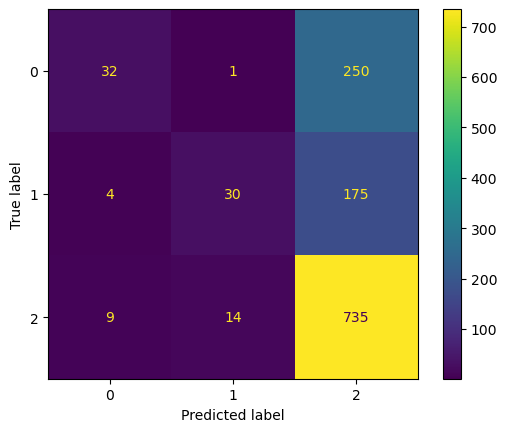

In [96]:
report_metrics(pred_np[:], ref_np[:])

In [97]:
pd.Series(pred_np).value_counts()

2    1160
1      45
0      45
Name: count, dtype: int64

As observed in the metrics report, the performance of a pretrained model on our data is not optimal and can be improved using fine tunning.

## Model fine tuning

In this section, a pretrained model is used as the basis for fine tunning a new model with a labeled dataset. In this case we will use the previosuly labeled dataset obntained from telegram messages.

In [103]:
# load Dataset from Pandas DataFrame
dataset = Dataset.from_pandas(merged_df[["text", "target", "sentiment","id"]])
ds = dataset.train_test_split()

In [101]:
# Load tokenizer and do some preprocessing before training
model_checkpoint = "distilbert-base-uncased"

tokenizer = AutoTokenizer.from_pretrained(model_checkpoint)
def preprocess_function(examples):
    return tokenizer(examples["text"], padding="max_length", truncation=True)

encoded_dataset = ds.map(preprocess_function, batched=True)
encoded_dataset = encoded_dataset.remove_columns(["text", "sentiment", "id"])
encoded_dataset = encoded_dataset.rename_column("target", "labels")
encoded_dataset.set_format("torch")

In [104]:
# DataLoaders wrapping and splitting into train and eval
from torch.utils.data import DataLoader

train_dataloader = DataLoader(encoded_dataset["train"], shuffle=True, batch_size=8)
eval_dataloader = DataLoader(encoded_dataset["test"], batch_size=8)

### Model training

In [105]:
from transformers import AutoModelForSequenceClassification

TRAIN_MODEL = True

if not TRAIN_MODEL:
    model_name = "models/telegram_multiclass_1"
else: 
    model_name = model_checkpoint

model = AutoModelForSequenceClassification.from_pretrained(model_name, num_labels=3)

Some weights of DistilBertForSequenceClassification were not initialized from the model checkpoint at distilbert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight', 'pre_classifier.bias', 'pre_classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [106]:
# in case device was used before
torch.mps.empty_cache()

# Define optimizer
from torch.optim import AdamW
optimizer = AdamW(model.parameters(), lr=5e-5)

# Define scheduller
from transformers import get_scheduler
num_epochs = 3
num_training_steps = num_epochs * len(train_dataloader)
lr_scheduler = get_scheduler(
    name="linear", optimizer=optimizer, num_warmup_steps=0, num_training_steps=num_training_steps
)

# Device selection
device = torch.device("cuda") if torch.cuda.is_available() else torch.device("mps") if torch.backends.mps.is_available() else torch.device("cpu")
model.to(device)

DistilBertForSequenceClassification(
  (distilbert): DistilBertModel(
    (embeddings): Embeddings(
      (word_embeddings): Embedding(30522, 768, padding_idx=0)
      (position_embeddings): Embedding(512, 768)
      (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
      (dropout): Dropout(p=0.1, inplace=False)
    )
    (transformer): Transformer(
      (layer): ModuleList(
        (0-5): 6 x TransformerBlock(
          (attention): MultiHeadSelfAttention(
            (dropout): Dropout(p=0.1, inplace=False)
            (q_lin): Linear(in_features=768, out_features=768, bias=True)
            (k_lin): Linear(in_features=768, out_features=768, bias=True)
            (v_lin): Linear(in_features=768, out_features=768, bias=True)
            (out_lin): Linear(in_features=768, out_features=768, bias=True)
          )
          (sa_layer_norm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
          (ffn): FFN(
            (dropout): Dropout(p=0.1, inplace=False)
 

In [107]:
# Training loop

from tqdm.auto import tqdm

progress_bar = tqdm(range(num_training_steps))

model.train()
for epoch in range(num_epochs):
    for batch in train_dataloader:
        batch = {k: v.to(device) for k, v in batch.items()}
        outputs = model(**batch)
        loss = outputs.loss
        loss.backward()

        optimizer.step()
        lr_scheduler.step()
        optimizer.zero_grad()
        progress_bar.update(1)

  0%|          | 0/1407 [00:00<?, ?it/s]

### Metrics

running inference on mps

Class: positive:
Precision: 0.756198347107438
Recall: 0.6466431095406361
F1-score: 0.6971428571428573

Class: negative:
Precision: 0.6269430051813472
Recall: 0.5789473684210527
F1-score: 0.6019900497512438

Class: neutral:
Precision: 0.803680981595092
Recall: 0.8641160949868074
F1-score: 0.8328035600762873

Global metrics:
Accuracy: 0.7672
Precision (weighted): 0.7633803234907091
Recall (weighted): 0.7672
F1-score (weighted): 0.7634979580058116


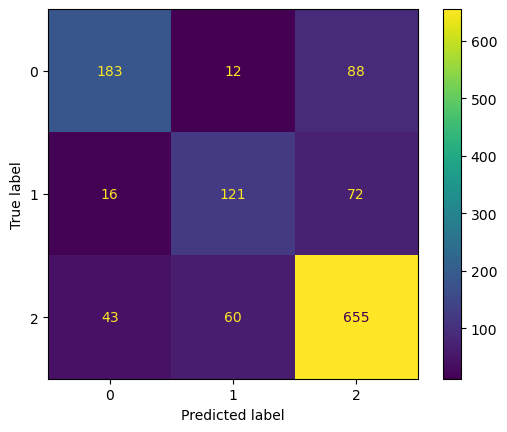

In [108]:
predictions, references = compute_metrics(model, eval_dataloader, device=device)
pred_np = predictions.cpu().numpy()
ref_np = references.cpu().numpy()
report_metrics(pred_np[:], ref_np[:])

With only 3750 training samples, the fine tunning already achieves a higher performance than a standard pretrained model. The process can be repetead with more labeled samples to obtain a better performance.

Finally, the model weights can be saved for future usage.

In [112]:
model.save_pretrained("models/telegram_multiclass_1")